<a href="https://colab.research.google.com/github/lucywowen/csci591_CCN/blob/main/hackathons/SDT_tutorial_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Psychophysics and Signal Detection Theory tutorial
*Based on the MATLAB tutorial by G.M. Boynton (CSHL June 2012), modified by Jason D. Yeatman & Brian A. Wandell (Stanford CNS core course, April 2013).*


## Signal Detection Theory
Suppose you want to determine if a subject can reliably detect a weak stimulus.  
A simple “did you see it?” task fails because a subject could always say “yes.”  
So we include *catch trials* (no-stimulus trials).

- Stimulus-present trials are **signal** trials.
- No-stimulus trials are **noise** trials.

SDT models an internal response that varies trial-to-trial. The observer says “yes” if the internal response exceeds a **criterion**.


In [1]:
# Imports and helper functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Normal distribution helpers matching the MATLAB tutorial names
normalpdf = lambda x, mu, sd: norm.pdf(x, loc=mu, scale=sd)
normalcdf = lambda x, mu, sd: norm.cdf(x, loc=mu, scale=sd)
normalinv = lambda p: norm.ppf(p)  # z-score (inverse CDF) for standard normal

np.random.seed(0)  # for reproducibility in simulation sections (optional)

## Initializing the parameters
Consider these as the distributions of internal responses to noise and signal trials.


In [2]:
noiseMean = 0
signalMean = 1
sd = 1

## Plot the signal and noise distributions

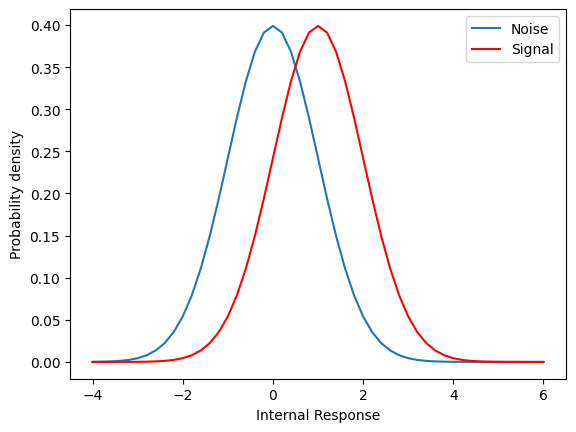

In [3]:
# Points at which we evaluate the PDFs
z = np.arange(-4, 6.0001, 0.2)

noise_y  = normalpdf(z, noiseMean, sd)
signal_y = normalpdf(z, signalMean, sd)

plt.figure()
plt.plot(z, noise_y, label="Noise")
plt.plot(z, signal_y, 'r-', label="Signal")
plt.xlabel("Internal Response")
plt.ylabel("Probability density")
plt.legend()
plt.show()

We next set a criterion that determines when the observer responds **Yes**.

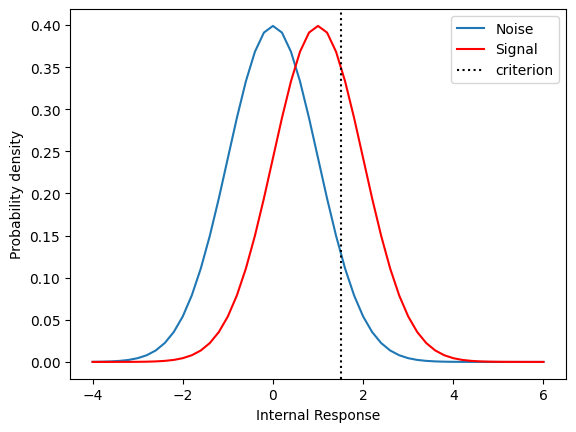

In [4]:
criterion = 1.5

plt.figure()
plt.plot(z, noise_y, label="Noise")
plt.plot(z, signal_y, 'r-', label="Signal")
yl = plt.ylim()
plt.plot([criterion, criterion], yl, 'k:', label="criterion")
plt.ylim(yl)
plt.xlabel("Internal Response")
plt.ylabel("Probability density")
plt.legend()
plt.show()

## Hits and false alarms: the basics of SDT

|           | Response "Yes" | Response "No" |
|---|---:|---:|
| **Signal present** | Hit | Miss |
| **Signal absent**  | False alarm | Correct rejection |


In [5]:
# Probability of a hit: P(x > criterion | signal)
pHit = 1 - normalcdf(criterion, signalMean, sd)

# Probability of a false alarm: P(x > criterion | noise)
pFA  = 1 - normalcdf(criterion, noiseMean, sd)

pHit, pFA

(np.float64(0.3085375387259869), np.float64(0.06680720126885809))

### Questions
1. Calculate the probability of a miss  
2. Calculate the probability of a correct rejection  


In [6]:
# 1) Miss: P(x <= criterion | signal)
pMiss = 1 - pHit

# 2) Correct rejection: P(x <= criterion | noise)
pCR = 1 - pFA

pMiss, pCR

(np.float64(0.6914624612740131), np.float64(0.9331927987311419))

In [7]:
# Display the full SDT contingency table
print("")
print('           |         Response     |')
print('  Signal   |  "Yes"    |  "No"    |')
print('  ---------------------------------')
print(f'  Present  |   {100*pHit:3.1f}%   |   {100*pMiss:3.1f}%   |')
print('  ---------+-----------+----------|')
print(f'  Absent   |   {100*pFA:3.1f}%   |   {100*pCR:3.1f}%   |')
print('  ---------------------------------')

# Overall performance when half trials are signal and half are noise
PC = (pHit + pCR) / 2
print(f'  Percent Correct: {100*PC:5.2f}%')


           |         Response     |
  Signal   |  "Yes"    |  "No"    |
  ---------------------------------
  Present  |   30.9%   |   69.1%   |
  ---------+-----------+----------|
  Absent   |   6.7%   |   93.3%   |
  ---------------------------------
  Percent Correct: 62.09%


### Questions about the parameters
3. If you shift your criterion very low or very high, what happens to performance?  
4. Percent correct is maximized when the criterion is halfway between the signal and noise means (equal payoffs). As an experimenter, how might you push subjects to increase/decrease criterion?  
5. There are two ways to affect performance by changing the internal-response distributions. Describe them.


## d′ (d-prime)
d′ is the separation between signal and noise means in units of the common standard deviation.


In [8]:
dPrime = (signalMean - noiseMean) / sd
print(f"dPrime = {dPrime:5.2f}")

dPrime =  1.00


## Estimating d′ from hits and false alarms
We can estimate d′ via the difference in z-scores:
\begin{aligned}
d' &= z(\mathrm{Hit}) - z(\mathrm{FA})
\end{aligned}


In [9]:
zHit = normalinv(pHit)
zFA  = normalinv(pFA)

dPrimeEst = zHit - zFA

zHit, zFA, dPrimeEst

(np.float64(-0.5000000000000001),
 np.float64(-1.4999999999999996),
 np.float64(0.9999999999999994))

### Question
6. Play with parameters: Does `dPrimeEst` stay constant for different criterion values? Try 4 criteria and report d′.


In [10]:
# Example: sweep a few criterion values and report estimated d'
criteria = [-0.5, 0.5, 1.5, 2.5]
rows = []
for c in criteria:
    ph = 1 - normalcdf(c, signalMean, sd)
    pfa = 1 - normalcdf(c, noiseMean, sd)
    # guard against 0 or 1 probabilities in case of extreme criteria
    eps = 1e-10
    ph = np.clip(ph, eps, 1-eps)
    pfa = np.clip(pfa, eps, 1-eps)
    d_est = normalinv(ph) - normalinv(pfa)
    rows.append((c, ph, pfa, d_est))

rows

[(-0.5,
  np.float64(0.9331927987311419),
  np.float64(0.6914624612740131),
  np.float64(0.9999999999999994)),
 (0.5,
  np.float64(0.6914624612740131),
  np.float64(0.3085375387259869),
  np.float64(1.0000000000000002)),
 (1.5,
  np.float64(0.3085375387259869),
  np.float64(0.06680720126885809),
  np.float64(0.9999999999999994)),
 (2.5,
  np.float64(0.06680720126885809),
  np.float64(0.006209665325776159),
  np.float64(0.9999999999999991))]

## The receiver operating characteristic (ROC) curve
An ROC curve plots hit rate vs false alarm rate as criterion varies.


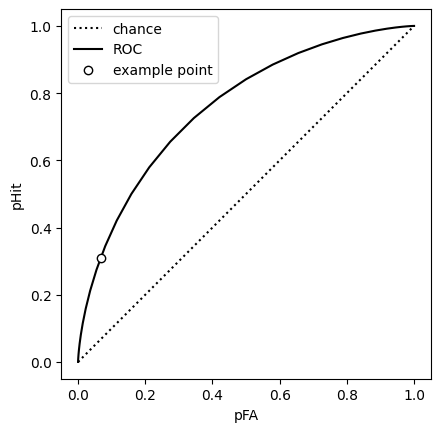

In [11]:
pHits = 1 - normalcdf(z, signalMean, sd)
pFAs  = 1 - normalcdf(z, noiseMean, sd)

plt.figure()
plt.plot([0, 1], [0, 1], 'k:', label="chance")
plt.plot(pFAs, pHits, 'k-', label="ROC")
plt.plot(pFA, pHit, 'ko', markerfacecolor='w', label="example point")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("pFA")
plt.ylabel("pHit")
plt.legend()
plt.show()

### Questions about the ROC
7. Add points marking the hit and false alarm rates for the 4 criteria from Question 6.  
8. Plot 4 ROC curves for changes in SD and signal strength (mean separation). How does ROC “bow” relate to d′?


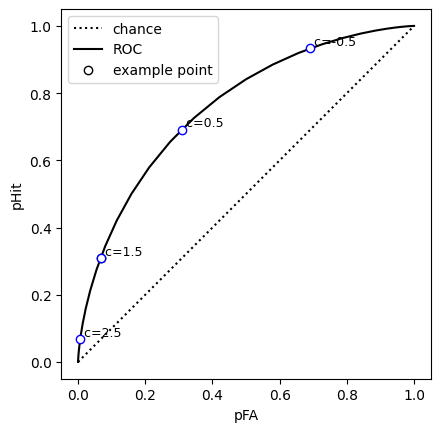

In [12]:
# Add the 4 example criterion points to the ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], 'k:', label="chance")
plt.plot(pFAs, pHits, 'k-', label="ROC")
plt.plot(pFA, pHit, 'ko', markerfacecolor='w', label="example point")

for c, ph, pfa, d_est in rows:
    plt.plot(pfa, ph, 'bo', markerfacecolor='w')
    plt.text(pfa, ph, f" c={c}", fontsize=9, va='bottom', ha='left')

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("pFA")
plt.ylabel("pHit")
plt.legend()
plt.show()

## Area under the ROC curve (AUC)
The AUC is a common summary of discriminability. We approximate it numerically with the trapezoid rule.


In [13]:
ROCarea = -np.trapz(pHits, pFAs)  # negative because curve traces right-to-left as criterion increases
ROCarea

/tmp/ipython-input-3852719179.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ROCarea = -np.trapz(pHits, pFAs)  # negative because curve traces right-to-left as criterion increases


np.float64(0.7594877760812615)

## Relationship between d′ and ROC area
For equal-variance Gaussians:
\begin{aligned}
d' = \sqrt{2}\,\Phi^{-1}(\mathrm{AUC})
\end{aligned}


In [14]:
dPrimeFromArea = np.sqrt(2) * normalinv(ROCarea)
dPrimeFromArea

np.float64(0.9965338260007142)

## Simulating a Yes/No experiment
We simulate internal responses for a series of trials and estimate d′ from simulated hit/FA rates.



Simulation of 100 trials:
           |       Response        |
  Signal   |  "Yes"    |  "No"     |
  ---------------------------------
  Present  |   34.7%   |   65.3%   |
  ---------+-----------+-----------|
  Absent   |   9.8%   |   90.2%   |
  ---------------------------------


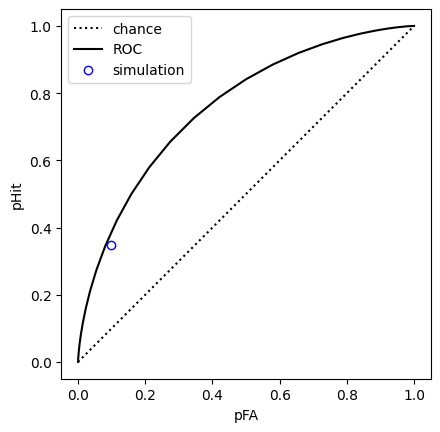

d-prime from simulation =  0.90


In [15]:
nTrials = 100
isSignal = (np.floor(np.random.rand(nTrials) + 0.5).astype(int) == 1)  # coin flip

# internal response
x = np.random.randn(nTrials) * sd
x[isSignal]  += signalMean
x[~isSignal] += noiseMean

# response is "Yes" if above criterion
response = x > criterion

pHitSim = response[isSignal].mean()
pFASim  = response[~isSignal].mean()

print("")
print(f"Simulation of {nTrials} trials:")
print('           |       Response        |')
print('  Signal   |  "Yes"    |  "No"     |')
print('  ---------------------------------')
print(f'  Present  |   {100*pHitSim:3.1f}%   |   {100*(1-pHitSim):3.1f}%   |')
print('  ---------+-----------+-----------|')
print(f'  Absent   |   {100*pFASim:3.1f}%   |   {100*(1-pFASim):3.1f}%   |')
print('  ---------------------------------')

# plot on ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], 'k:', label="chance")
plt.plot(pFAs, pHits, 'k-', label="ROC")
plt.plot(pFASim, pHitSim, 'bo', markerfacecolor='w', label="simulation")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("pFA")
plt.ylabel("pHit")
plt.legend()
plt.show()

# d-prime from simulated rates (clip to avoid inf)
eps = 1e-10
pHitSim_c = np.clip(pHitSim, eps, 1-eps)
pFASim_c  = np.clip(pFASim, eps, 1-eps)

dPrimeSim = normalinv(pHitSim_c) - normalinv(pFASim_c)
print(f"d-prime from simulation = {dPrimeSim:5.2f}")

## Questions about reliability and experimental design
9. How does the number of trials affect our estimates of d′?  
10. Does the criterion affect our ability to estimate d′ (variance of estimates)? What does this imply for ideal experiment design if your goal is to estimate d′?  

